# Task 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models, transforms
from sklearn.metrics import accuracy_score

### ResNet50

ResNet-50 is a convolutional neural network that is 50 layers deep. You can load a pretrained version of the neural network trained on more than a million images from the ImageNet database. The pretrained neural network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the neural network has learned rich feature representations for a wide range of images. The neural network has an image input size of 224-by-224.

https://pytorch.org/vision/0.18/models/generated/torchvision.models.resnet50.html

In [25]:
#The architecture of Resnet50 is visible on running below 3 code blocks.

In [2]:
model = models.resnet50(pretrained=True)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
model.fc = torch.nn.Identity()  # Remove last layer for feature extraction

In [4]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
# Define the transformation (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
# Feature extraction function
def extract_features(images):
    features = []
    with torch.no_grad():
        for img in images:
            img_tensor = transform(img).unsqueeze(0)
            feat = model(img_tensor).view(1, -1)  # Flatten to 1D
            features.append(feat.numpy())
    return np.concatenate(features)

In [23]:
heldout_features = {}

In [24]:
# Extract and store features only once for each heldout dataset
def get_or_extract_features(dataset_name, dataset_data):
    if dataset_name not in heldout_features:
        heldout_features[dataset_name] = extract_features(dataset_data)    
    return heldout_features[dataset_name]

In [8]:
# Compute class prototypes
def compute_prototypes(features, labels):
    prototypes = {}
    for label in np.unique(labels):
        prototypes[label] = features[labels == label].mean(axis=0)
    return prototypes

In [9]:
# Contrastive alignment
def prototype_contrastive_alignment(prev_prototypes, curr_prototypes, alpha=0.5):
    aligned_prototypes = {}
    for cls in curr_prototypes.keys():
        if cls in prev_prototypes:
            aligned_prototypes[cls] = alpha * prev_prototypes[cls] + (1 - alpha) * curr_prototypes[cls]
        else:
            aligned_prototypes[cls] = curr_prototypes[cls]
    return aligned_prototypes

In [10]:
# Initialize variables
performance_matrix = np.zeros((20, 20))
prev_prototypes = None

In [11]:
def cosine_pseudo_labels(features, prototypes, top_fraction=0.8):
    """
    Generate pseudo-labels using cosine similarity and return both predictions and similarities for all inputs.

    Args:
    - features (numpy.ndarray): The feature representations of input samples.
    - prototypes (dict): A dictionary with class labels as keys and prototype vectors as values.
    - top_fraction (float): Fraction of high-confidence samples to select for constructing prototypes.

    Returns:
    - pseudo_labels (numpy.ndarray): Predicted pseudo-labels for the features.
    - similarities (numpy.ndarray): Cosine similarities for each feature with the prototypes.
    """
    proto_matrix = np.array(list(prototypes.values()))  # Prototype matrix
    proto_labels = list(prototypes.keys())             # Class labels for prototypes

    # Normalize prototypes for cosine similarity
    proto_norms = np.linalg.norm(proto_matrix, axis=1, keepdims=True)
    normalized_prototypes = proto_matrix / proto_norms

    similarities, predictions = [], []

    for feature in features:
        # Normalize the feature vector
        feature_norm = np.linalg.norm(feature)
        normalized_feature = feature / feature_norm

        # Compute cosine similarity between feature and all prototypes
        sim = normalized_prototypes @ normalized_feature
        similarities.append(sim)
        predictions.append(proto_labels[np.argmax(sim)])

    similarities = np.array(similarities)
    predictions = np.array(predictions)

    # Confidence is the gap between the highest and second-highest similarity scores
    top_similarities = np.sort(similarities, axis=1)[:, -2:]  # Top two similarities
    confidences = top_similarities[:, 1] - top_similarities[:, 0]

    # Select top_fraction of high-confidence indices
    num_select = int(len(confidences) * top_fraction)
    selected_indices = np.argsort(confidences)[-num_select:]  # Select top confident samples

    return predictions, similarities, selected_indices


In [26]:
"""


# To extract features using Resnet50 architecture, uncomment this block.

train1 = torch.load('part_one_dataset/train_data/1_train_data.tar.pth')
train1_images = train1['data']
train1_labels = train1['targets']

train1_features = extract_features(train1_images)


prototype1 = compute_prototypes(train1_features, train1_labels)

prev_prototypes = prototype1


test1 = torch.load('part_one_dataset/eval_data/1_eval_data.tar.pth')
test1_images = test1['data']
test1_labels = test1['targets']

test1_features = get_or_extract_features(test1_images)

predictions, _ , _ = cosine_pseudo_labels(test1_features, prototype1)
accuracy = accuracy_score(test1_labels, predictions)
print(accuracy)

performance_matrix[0][0] = accuracy*100

"""

"\n\n\n# To extract features using Resnet50 architecture, uncomment this block.\n\ntrain1 = torch.load('part_one_dataset/train_data/1_train_data.tar.pth')\ntrain1_images = train1['data']\ntrain1_labels = train1['targets']\n\ntrain1_features = extract_features(train1_images)\n\n\nprototype1 = compute_prototypes(train1_features, train1_labels)\n\nprev_prototypes = prototype1\n\n\ntest1 = torch.load('part_one_dataset/eval_data/1_eval_data.tar.pth')\ntest1_images = test1['data']\ntest1_labels = test1['targets']\n\ntest1_features = get_or_extract_features(test1_images)\n\npredictions, _ , _ = cosine_pseudo_labels(test1_features, prototype1)\naccuracy = accuracy_score(test1_labels, predictions)\nprint(accuracy)\n\nperformance_matrix[0][0] = accuracy*100\n\n"

In [13]:
### This block can be run after downloading features from https://github.com/tusharsahu007/CS771-Mini-project-2 and placing in the same directory as this file.

train1 = torch.load('part_one_dataset/train_data/1_train_data.tar.pth')
train1_images = train1['data']
train1_labels = train1['targets']

train1_features = np.load(f'train_features1.npy')


prototype1 = compute_prototypes(train1_features, train1_labels)

prev_prototypes = prototype1


test1 = torch.load('part_one_dataset/eval_data/1_eval_data.tar.pth')
test1_images = test1['data']
test1_labels = test1['targets']

test1_features = np.load(f'test_features1.npy')

predictions, _ , _ = cosine_pseudo_labels(test1_features, prototype1)
accuracy = accuracy_score(test1_labels, predictions)
print(accuracy)

performance_matrix[0][0] = accuracy*100

0.7992


/var/folders/p3/gt76pp616n3fjqr1r8rd1r6w0000gn/T/ipykernel_6537/2965514610.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train1 = torch.load('part_one_dataset/train_da

In [17]:
train1_features.shape

(2500, 2048)

In [ ]:
"""


# To extract features using Resnet50 architecture, uncomment this block.
# The feature extraction takes around 2 minute for a training dataset on Macbook Air M1 i.e. the notebook may take around 30 minutes on M1 machine.

# Update loop for D2 to D10
for i in range(2, 11):
    # Load and extract features
    train = torch.load(f'part_two_dataset/train_data/{i-10}_train_data.tar.pth')
    train_images = train['data']
    features = extract_features(train_images)

    # Predict pseudo-labels using cosine similarity and get similarities
    pseudo_labels, similarities, selected_indices = cosine_pseudo_labels(features, prev_prototypes)

    # Select features and labels based on top_fraction of similarities
    reliable_features = features[selected_indices]
    reliable_labels = pseudo_labels[selected_indices]

    # Compute and align prototypes
    prototypes = compute_prototypes(reliable_features, reliable_labels)
    prototypes = prototype_contrastive_alignment(prev_prototypes, prototypes)

    # Evaluate on held-out datasets
    for j in range(1, i + 1):
    
        test = torch.load(f'part_one_dataset/eval_data/{j}_eval_data.tar.pth')  

        test_images = test['data']
        test_labels = test['targets']
        test_features = get_or_extract_features(f'D{j}', test_images)

        # Predict using the updated prototypes
        predictions, _, _ = cosine_pseudo_labels(test_features, prototypes)
        accuracy = accuracy_score(test_labels, predictions)
        print(accuracy)
        performance_matrix[i-1, j-1] = accuracy * 100

    prev_prototypes = prototypes




"""

In [20]:
"""
This block can be run after downloading the features from    and placing it in the directory of this file.
"""


# Update loop for D2 to D10
for i in range(2, 11):
    # Load and extract features
    train = torch.load(f'part_one_dataset/train_data/{i}_train_data.tar.pth')
    train_images = train['data']
    features = np.load(f'train_features{i}.npy')

    # Predict pseudo-labels using cosine similarity and get similarities
    pseudo_labels, similarities, selected_indices = cosine_pseudo_labels(features, prev_prototypes)

    # Select features and labels based on top_fraction of similarities
    reliable_features = features[selected_indices]
    reliable_labels = pseudo_labels[selected_indices]

    # Compute and align prototypes
    prototypes = compute_prototypes(reliable_features, reliable_labels)
    prototypes = prototype_contrastive_alignment(prev_prototypes, prototypes)

    # Evaluate on held-out datasets
    for j in range(1, i + 1):
        test = torch.load(f'part_one_dataset/eval_data/{j}_eval_data.tar.pth')
        test_images = test['data']
        test_labels = test['targets']
        test_features = np.load(f'test_features{j}.npy')


        # Predict using the updated prototypes
        predictions, _, _ = cosine_pseudo_labels(test_features, prototypes)
        accuracy = accuracy_score(test_labels, predictions)
        print(accuracy)
        performance_matrix[i-1, j-1] = accuracy * 100

    prev_prototypes = prototypes


/var/folders/p3/gt76pp616n3fjqr1r8rd1r6w0000gn/T/ipykernel_6537/1037781765.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train = torch.load(f'part_one_dataset/train_da

0.7448
0.7556
0.7472
0.7568


/var/folders/p3/gt76pp616n3fjqr1r8rd1r6w0000gn/T/ipykernel_6537/1037781765.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test = torch.load(f'part_one_dataset/eval_dat

0.7624
0.7416
0.7532
0.7592


/var/folders/p3/gt76pp616n3fjqr1r8rd1r6w0000gn/T/ipykernel_6537/1037781765.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test = torch.load(f'part_one_dataset/eval_dat

0.7564
0.7416
0.748
0.7604


/var/folders/p3/gt76pp616n3fjqr1r8rd1r6w0000gn/T/ipykernel_6537/1037781765.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test = torch.load(f'part_one_dataset/eval_dat

0.7564
0.7512
0.7408
0.7456


/var/folders/p3/gt76pp616n3fjqr1r8rd1r6w0000gn/T/ipykernel_6537/1037781765.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test = torch.load(f'part_one_dataset/eval_dat

0.7564
0.756
0.7512
0.744


/var/folders/p3/gt76pp616n3fjqr1r8rd1r6w0000gn/T/ipykernel_6537/1037781765.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train = torch.load(f'part_one_dataset/train_da

0.7364
0.7468
0.754
0.7548
0.746


/var/folders/p3/gt76pp616n3fjqr1r8rd1r6w0000gn/T/ipykernel_6537/1037781765.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test = torch.load(f'part_one_dataset/eval_dat

0.7412
0.7364
0.734
0.7488
0.752


/var/folders/p3/gt76pp616n3fjqr1r8rd1r6w0000gn/T/ipykernel_6537/1037781765.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test = torch.load(f'part_one_dataset/eval_dat

0.7544
0.746
0.7396
0.7388
0.7388


/var/folders/p3/gt76pp616n3fjqr1r8rd1r6w0000gn/T/ipykernel_6537/1037781765.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test = torch.load(f'part_one_dataset/eval_dat

0.7348
0.7492
0.7552
0.7548
0.746
0.7416


/var/folders/p3/gt76pp616n3fjqr1r8rd1r6w0000gn/T/ipykernel_6537/1037781765.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test = torch.load(f'part_one_dataset/eval_dat

0.7388
0.742
0.7204
0.734


/var/folders/p3/gt76pp616n3fjqr1r8rd1r6w0000gn/T/ipykernel_6537/1037781765.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test = torch.load(f'part_one_dataset/eval_dat

0.7504
0.7524
0.7492
0.7424
0.742
0.7384


/var/folders/p3/gt76pp616n3fjqr1r8rd1r6w0000gn/T/ipykernel_6537/1037781765.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test = torch.load(f'part_one_dataset/eval_dat

0.7424
0.7232
0.762


/var/folders/p3/gt76pp616n3fjqr1r8rd1r6w0000gn/T/ipykernel_6537/1037781765.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test = torch.load(f'part_one_dataset/eval_dat

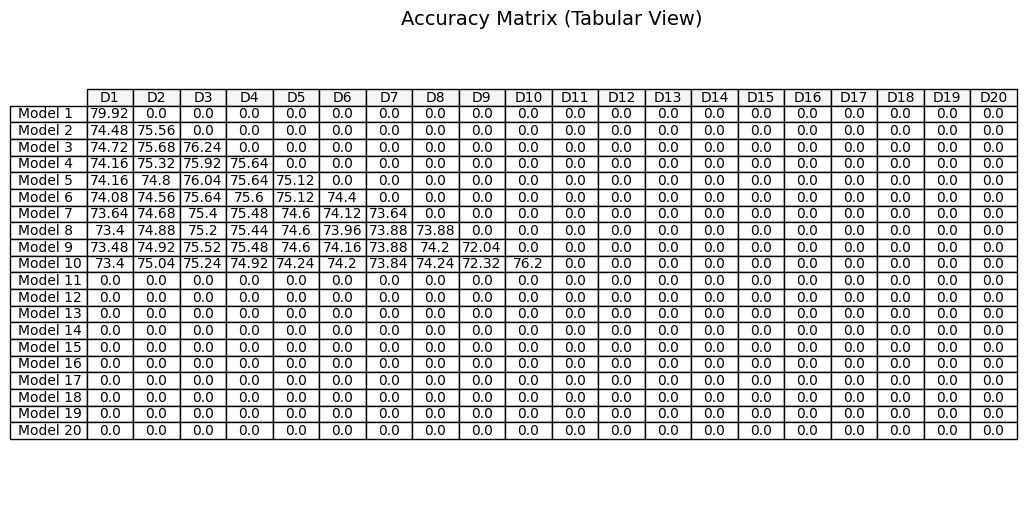

In [21]:
# Convert performance matrix into a DataFrame for better formatting
df = pd.DataFrame(performance_matrix, 
                  index=[f"Model {i+1}" for i in range(performance_matrix.shape[0])], 
                  columns=[f"D{j}" for j in range(1, performance_matrix.shape[1]+1)])

# Plot table
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust size as needed
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.round(2).values,  # Round values to 2 decimal places
                 rowLabels=df.index, 
                 colLabels=df.columns, 
                 cellLoc="center", 
                 loc="center",
                 colColours=["#f5f5f5"] * len(df.columns))  # Optional: light column background color

# Adjust font size for readability
table.auto_set_font_size(False)
table.set_fontsize(10)

plt.title("Accuracy Matrix (Tabular View)", fontsize=14)
plt.show()


In [22]:
import pickle

# Save the state
model_state = {
    "prev_prototypes": prev_prototypes,
    "performance_matrix": performance_matrix
}

with open("model_state.pkl", "wb") as f:
    pickle.dump(model_state, f)

print("Model state saved!")


Model state saved!
